# Figure Machine

In [43]:
import mne
from wavelets import *
import matplotlib.pyplot as plt
import pywt
import numpy as np

### Denoising Demonstration

In [2]:
s9cprod_a = "/pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_09_2_a_112-epo.fif"

In [3]:
s9prodadata = mne.read_epochs(s9cprod_a)

Reading /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_09_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated


In [4]:
def dwt_denoise(data, wavelet='db4', level=7):
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[-1] = np.zeros_like(coefficients[-1]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[-2] = np.zeros_like(coefficients[-2]) #d2
    return pywt.waverec(coefficients, wavelet)[:len(data)]

In [5]:
s9prodadata = s9prodadata.crop(-0.2, 0.6)
noisy_meg001 = s9prodadata[0]._data[0][0]
denoised_meg001 = dwt_denoise(data=noisy_meg001, wavelet='db4', level=5)

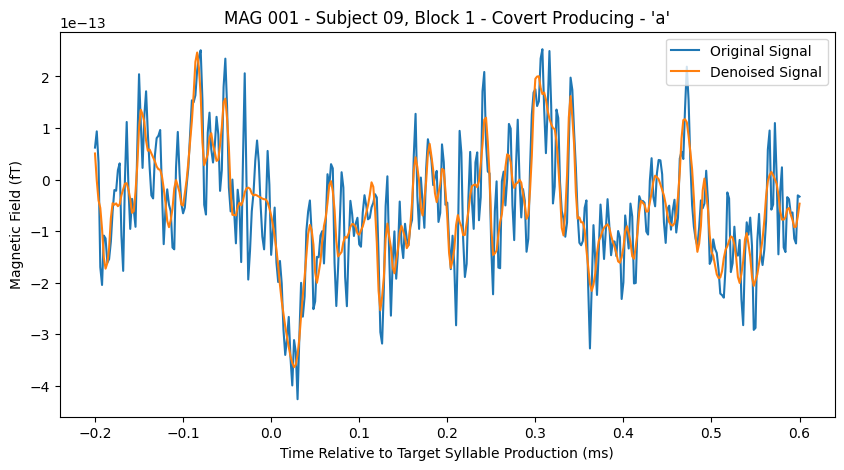

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(s9prodadata.times, noisy_meg001, label="Original Signal")
plt.plot(s9prodadata.times,denoised_meg001, label="Denoised Signal" )
plt.xlabel("Time Relative to Target Syllable Production (ms)")
plt.ylabel("Magnetic Field (fT)")
plt.legend(loc='upper right')
plt.title("MAG 001 - Subject 09, Block 1 - Covert Producing - 'a'")
plt.savefig("S9-B1-CP-a-noise-denoise.png", dpi=300, bbox_inches='tight')

In [68]:
s9prodadata.ch_names[0]

'MEG 001'

### Z-Score Distributions

In [3]:
zscore_coefs_file = "/pasteur/appa/scratch/cbangu/coefficients/covert_producing/BCOM_22_3_e_114_coefficients.npy"
zscore_coefs = np.load(zscore_coefs_file, mmap_mode="r")

In [47]:
zscore_coefs[0][125].shape

(100, 401)

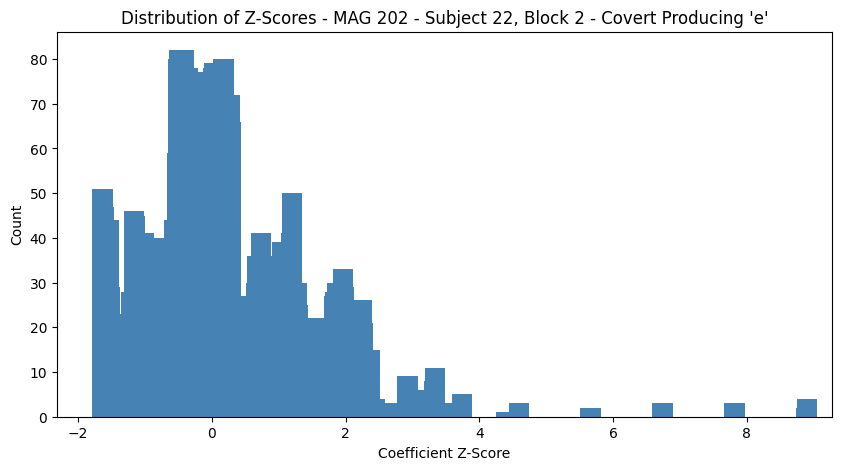

In [70]:
plt.figure(figsize=(10, 5))
plt.hist(zscore_coefs[0][200], width=0.3, color=['steelblue']*401)
plt.xlabel("Coefficient Z-Score")
plt.ylabel("Count")
plt.title("Distribution of Z-Scores - MAG 202 - Subject 22, Block 2 - Covert Producing 'e'")
plt.savefig("Zscores-cpe.png")

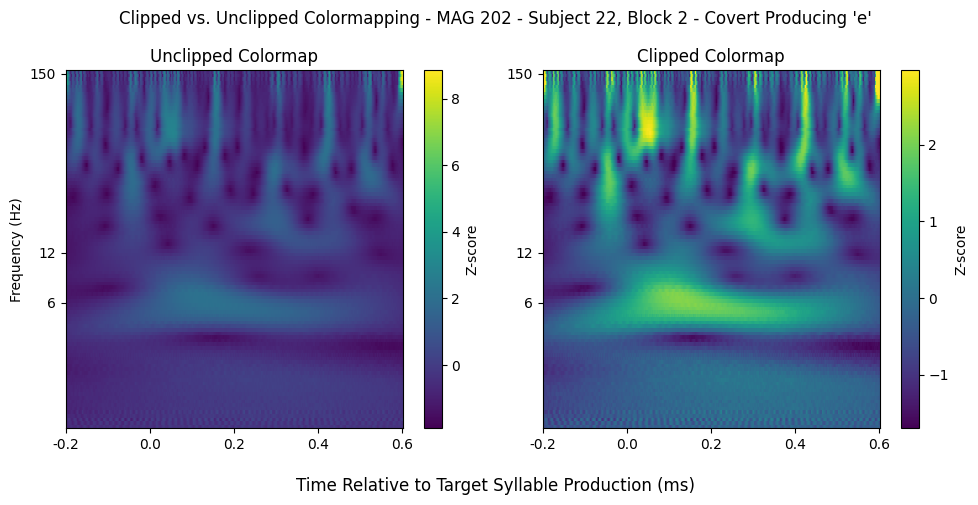

In [8]:
n_times = 401
times = np.linspace(-0.2, 0.6, n_times)
freqs = np.logspace(np.log10(1), np.log10(150), 100)



# Choose a few tick positions in sample‐space:
tick_idxs = [0, 100, 200, 300, 400]
tick_labels = [f"{times[i]:.1f}" for i in tick_idxs]

# Choose some tick indices for the y-axis (frequency bins)
freq_tick_idxs = [35, 49, 99]  # for example: lowest, mid, and highest frequency
freq_tick_labels = [f"{freqs[i]:.0f}" for i in freq_tick_idxs]




import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)  # wider figure

# Plot 1

qm = ax1.pcolormesh(zscore_coefs[0][200])
ax1.set_xticks(tick_idxs)
ax1.set_xticklabels(tick_labels)
ax1.set_yticks(freq_tick_idxs)
ax1.set_yticklabels(freq_tick_labels)
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("Unclipped Colormap")
cb1 = fig.colorbar(qm, ax=ax1)  # individual colorbar
cb1.set_label("Z-score")

# Plot 2
qm2 = ax2.pcolormesh(zscore_coefs[0][200], vmin=-1.7007, vmax=2.9722)
ax2.set_xticks(tick_idxs)
ax2.set_xticklabels(tick_labels)
ax2.set_yticks(freq_tick_idxs)
ax2.set_yticklabels(freq_tick_labels)
ax2.set_title("Clipped Colormap")
cb2 = fig.colorbar(qm2, ax=ax2)  # individual colorbar
cb2.set_label("Z-score")


# Shared x-label for both subplots
fig.supxlabel("Time Relative to Target Syllable Production (ms)")
fig.suptitle("Clipped vs. Unclipped Colormapping - MAG 202 - Subject 22, Block 2 - Covert Producing 'e'")

fig.tight_layout()
fig.savefig("unclipped-clipped-scalogram.png",
           dpi=300,
           bbox_inches='tight'
)



### 16x16 Scalogram

In [4]:
from plotting import ScalogramPlotter

In [5]:
plotter = ScalogramPlotter(dimensions=(16, 16), 
                               cmap='viridis',
                               index_list=np.arange(0, 247),
                               data_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
                               save_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
                               resolution=300, 
                               vmin=-1.7007, 
                               vmax=2.9722)

In [6]:
fig = plotter.plot_many(zscore_coefs[0])

plotting 0s for channel index: 247
plotting 0s for channel index: 248
plotting 0s for channel index: 249
plotting 0s for channel index: 250
plotting 0s for channel index: 251
plotting 0s for channel index: 252
plotting 0s for channel index: 253
plotting 0s for channel index: 254
plotting 0s for channel index: 255


In [12]:
fig.suptitle(
    "Spatio-Spectral-Temporal Spectrogram – Subject 22, Block 2 – Covert Producing 'e'",
    y=0.97
)
fig.savefig("ssts-s22-b2-cp-e.png", dpi=300)

### Wavelets

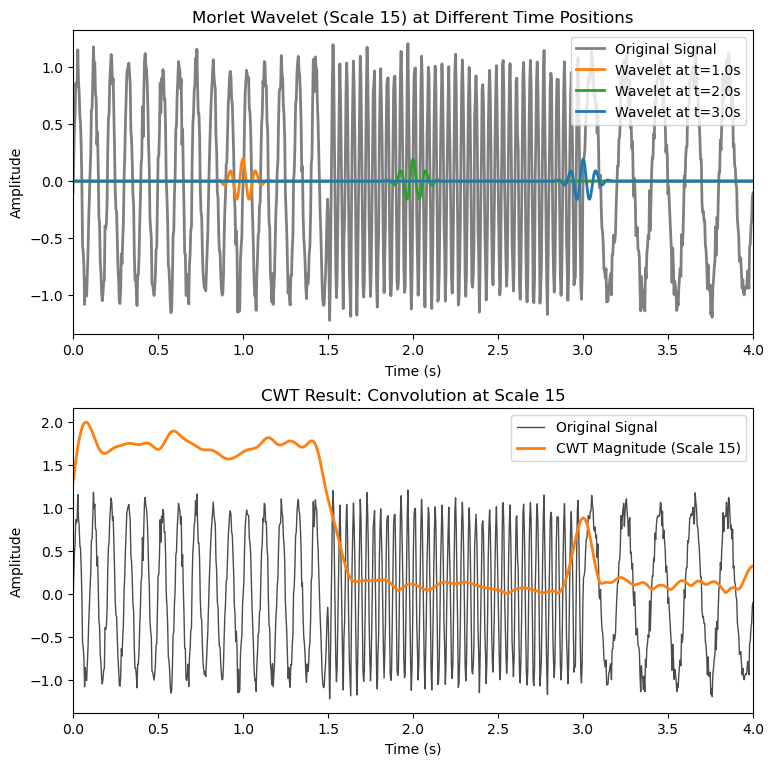

In [56]:
from scipy import signal
import matplotlib.patches as patches

# Create a test signal with multiple frequency components
t = np.linspace(0, 4, 1000)
# Signal with different frequencies at different times
test_signal = (np.sin(2*np.pi*10*t) * (t < 1.5) + 
               np.sin(2*np.pi*25*t) * (t >= 1.5) * (t < 3) +
               np.sin(2*np.pi*5*t) * (t >= 3))

# Add some noise
test_signal += 0.1 * np.random.randn(len(t))

# Define scales for demonstration
scales_demo = [5, 15, 30, 60]  # Different scales to show
colors = ['tab:orange', 'tab:green', 'tab:blue']

# Create the comprehensive figure
fig = plt.figure(figsize=(8, 16))  # Make figure taller for vertical stacking

ax = plt.subplot(4, 1, 3)  # Use 4 rows, 1 column, plot in row 3
selected_scale = 15
selected_positions = [1.0, 2.0, 3.0]  # Time positions to show

plt.plot(t, test_signal, 'k-', linewidth=2, alpha=0.5, label='Original Signal')

for i, pos in enumerate(selected_positions):
    # Create wavelet centered at this position
    t_shift = t - pos
    # Only show wavelets within reasonable bounds
    mask = np.abs(t_shift) < 0.5
    if np.any(mask):
        wavelet_shifted = np.zeros_like(t)
        wavelet_shifted[mask] = np.real(signal.morlet2(np.sum(mask), selected_scale))
        plt.plot(t, wavelet_shifted, color=colors[i], linewidth=2, 
                label=f'Wavelet at t={pos}s')

plt.title(f'Morlet Wavelet (Scale {selected_scale}) at Different Time Positions', fontsize=12)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.xlim(0, 4)

# 4. Show convolution result at one scale
ax4 = plt.subplot(4, 1, 4)  # Use row 4 for this plot
# Compute CWT for the selected scale
cwt_result = signal.cwt(test_signal, signal.morlet2, [selected_scale])
cwt_magnitude = np.abs(cwt_result[0])

plt.plot(t, test_signal, 'k-', linewidth=1, alpha=0.7, label='Original Signal')
plt.plot(t, cwt_magnitude, color='tab:orange', linewidth=2, label=f'CWT Magnitude (Scale {selected_scale})')
plt.title(f'CWT Result: Convolution at Scale {selected_scale}', fontsize=12)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0, 4)

# Add annotations to show the process
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)
plt.show()


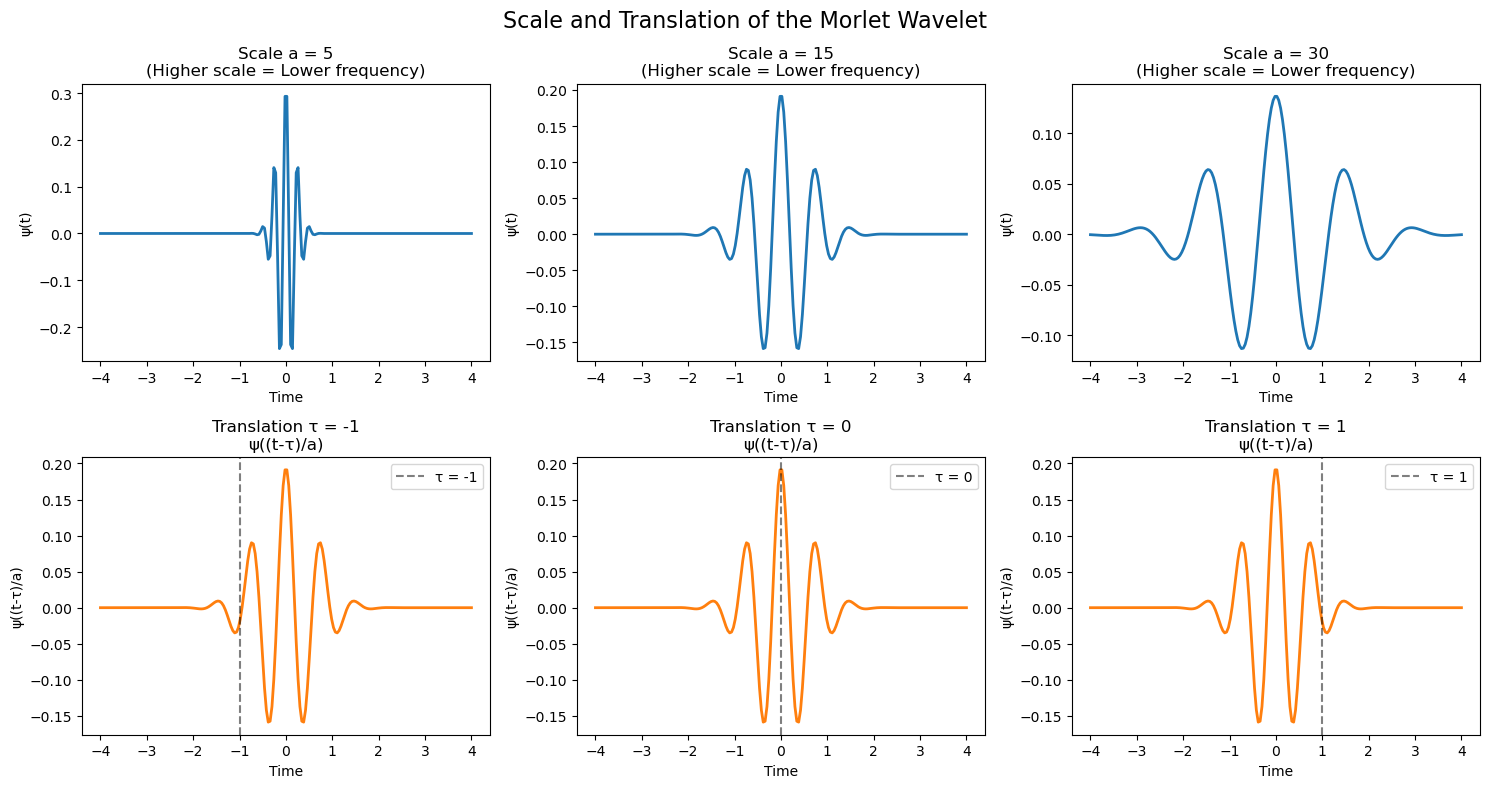

CWT Formula: CWT(a,τ) = (1/√a) ∫ x(t) ψ*((t-τ)/a) dt
Where:
- a = scale parameter (inverse of frequency)
- τ = translation parameter (time shift)
- ψ = mother wavelet (Morlet)
- * = complex conjugate


In [49]:

# Additional figure showing the mathematical concept
fig2, axes = plt.subplots(2, 3, figsize=(15, 8))
fig2.suptitle('Scale and Translation of the Morlet Wavelet', fontsize=16)

# Show effect of scaling
t_base = np.linspace(-4, 4, 200)
scales_to_show = [5, 15, 30]

for i, scale in enumerate(scales_to_show):
    axes[0, i].plot(t_base, np.real(signal.morlet2(len(t_base), scale)), linewidth=2)
    axes[0, i].set_title(f'Scale a = {scale}\n(Higher scale = Lower frequency)', fontsize=12)
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('ψ(t)')

# Show effect of translation
base_wavelet = np.real(signal.morlet2(len(t_base), 15))
translations = [-1, 0, 1]

for i, tau in enumerate(translations):
    t_shifted = t_base - tau
    axes[1, i].plot(t_base, base_wavelet, color='tab:orange', linewidth=2)
    axes[1, i].axvline(tau, color='k', linestyle='--', alpha=0.5, label=f'τ = {tau}')
    axes[1, i].set_title(f'Translation τ = {tau}\nψ((t-τ)/a)', fontsize=12)
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('ψ((t-τ)/a)')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

print("CWT Formula: CWT(a,τ) = (1/√a) ∫ x(t) ψ*((t-τ)/a) dt")
print("Where:")
print("- a = scale parameter (inverse of frequency)")
print("- τ = translation parameter (time shift)")
print("- ψ = mother wavelet (Morlet)")
print("- * = complex conjugate")

In [ ]:
# 1. Define signal
fs = 500
t = np.linspace(0, 1, fs)
x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 50 * t)  # two sinusoids

# 2. Compute CWT with Morlet wavelet
scales = np.arange(1, 128)
coefs, freqs = pywt.cwt(x, scales, 'cmor1.5-1.0', sampling_period=1/fs)

# 3. Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Panel 1: Signal
axs[0].plot(t, x)
axs[0].set_title("Signal $x(t)$")
axs[0].set_ylabel("Amplitude")

# Panel 2: Example Morlet wavelets at different scales
from scipy.signal import morlet
for scale, offset in zip([10, 30, 60], [0.3, 0.5, 0.7]):
    width = 6
    wavelet = morlet(M=fs, w=5.0, s=scale)
    axs[1].plot(t, np.real(wavelet) * 0.5 + offset, label=f'scale={scale}')
axs[1].set_title("Morlet wavelet $\psi_{a,b}(t)$ at different scales")
axs[1].legend()

# Panel 3: Scalogram (magnitude)
axs[2].imshow(np.abs(coefs), extent=[0, 1, freqs[-1], freqs[0]],
              aspect='auto', cmap='viridis')
axs[2].set_title("Magnitude Scalogram $|W_x(a,b)|$")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

### ROIS

In [3]:
subjects_dir = mne.get_config('SUBJECTS_DIR')
print(subjects_dir)

/Users/ciprianbangu/mne_data/MNE-fsaverage-data


In [41]:
from mne import read_labels_from_annot
import mne

labels_hcp = mne.read_labels_from_annot(
    subject='fsaverage',
    parc='HCPMMP1',
    hemi='lh',
    subjects_dir=subjects_dir
)

labels_aparc = mne.read_labels_from_annot(
    subject='fsaverage',
    parc='aparc',
    hemi='lh',
    subjects_dir=subjects_dir
)

# from from Sheets et al. 2021 
sma_labels = [label for label in labels_hcp if 'L_6ma_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_6mp_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_SCEF_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_SFL_ROI-lh' in label.name][0]


# commonly attirbuted
broca_labels = [label for label in labels_hcp if "L_44_ROI-lh" in label.name][0] +\
        [label for label in labels_hcp if "L_45_ROI-lh" in label.name][0]


# in the name
stg_labels = [label for label in labels_aparc if 'superiortemporal-lh' in label.name][0]

# in the name
mtg_labels = [label for label in labels_aparc if 'middletemporal-lh' in label.name][0]

# from Eckert et al. 2021
spt_labels = [label for label in labels_hcp if 'PSL' in label.name][0]

# Plot on inflated brain
brain = mne.viz.Brain(
    subject='fsaverage',
    hemi='lh',
    surf='inflated',
    background='white',
    subjects_dir=subjects_dir,
    cortex='low_contrast'
)

# Add labels

brain.add_label(sma_labels, color='crimson', borders=True)
brain.add_label(broca_labels, color='blue', borders=True) 
brain.add_label(stg_labels, color='green', borders=True)
brain.add_label(spt_labels, color='yellow', borders=True)

brain.show_view('lateral')

Reading labels from parcellation...
   read 181 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.HCPMMP1.annot
Reading labels from parcellation...
   read 35 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
